# Fig3: Dissecting the structural basis of burst and sustained dynamics through domain swapping


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import arviz as az


In [2]:
df = pd.read_csv("~/Thomson Lab Dropbox/David Larios/activedrops/main/090124-chimeras100nM-RT/2p5ul_TMBmix-1ulDNA100nM_/output_data/merged_expression_PIV.csv")

df


,condition,subcondition,time (s),Time_min,Time_h,Mean Intensity,Protein Concentration_ng_ul,Protein Concentration_nM,Number of Protein Molecules,Rate of Change of Protein Molecules per Second,...,dcev [1]_mean,shear [1/s]_mean,strain [1/s]_mean,vector direction [degrees]_mean,correlation length [m]_mean,distance [m]_mean,power [W]_mean,work [J]_mean,time (min),time (h)
0,A-RT,Rep1,0,0.000000,0.000000,0.376219,0.013725,0.308437,3.701249e+08,NaN,...,15.756792,3.077541e-07,-1.858536e-07,-49.269162,0.000407,0.000000,2.668220e-21,2.668220e-21,0.000000,0.000000
1,A-RT,Rep1,40,0.666667,0.011111,0.307614,0.011223,0.252192,3.026306e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A-RT,Rep1,80,1.333333,0.022222,0.000000,0.000000,0.000000,0.000000e+00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A-RT,Rep1,120,2.000000,0.033333,0.212872,0.007766,0.174520,2.094235e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A-RT,Rep1,160,2.666667,0.044444,0.390446,0.014244,0.320101,3.841213e+08,NaN,...,20.310783,-9.548041e-08,-1.719639e-07,6.307186,0.000401,0.000001,7.122923e-22,3.380512e-21,2.666667,0.044444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37875,negative,Rep1,168760,2812.666667,46.877778,0.000000,0.000000,0.000000,0.000000e+00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37876,negative,Rep1,168800,2813.333333,46.888889,0.000000,0.000000,0.000000,0.000000e+00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37877,negative,Rep1,168840,2814.000000,46.900000,0.000000,0.000000,0.000000,0.000000e+00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37878,negative,Rep1,168880,2814.666667,46.911111,0.000000,0.000000,0.000000,0.000000e+00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.columns

Index(['condition', 'subcondition', 'time (s)', 'Time_min', 'Time_h',
       'Mean Intensity', 'Protein Concentration_ng_ul',
       'Protein Concentration_nM', 'Number of Protein Molecules',
       'Rate of Change of Protein Molecules per Second',
       'Translation Rate aa_s', 'Unnamed: 0', 'frame', 'x [m]_mean',
       'y [m]_mean', 'u [m/s]_mean', 'v [m/s]_mean', 'data type [-]_mean',
       'vorticity [1/s]_mean', 'velocity magnitude [m/s]_mean',
       'divergence [1/s]_mean', 'dcev [1]_mean', 'shear [1/s]_mean',
       'strain [1/s]_mean', 'vector direction [degrees]_mean',
       'correlation length [m]_mean', 'distance [m]_mean', 'power [W]_mean',
       'work [J]_mean', 'time (min)', 'time (h)'],
      dtype='object')

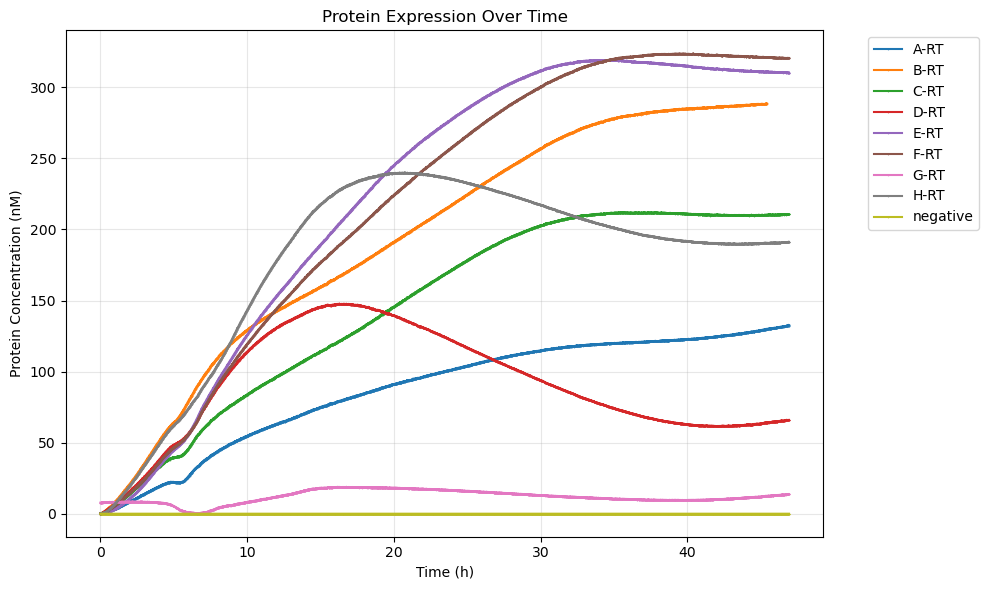

In [4]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot each condition
for condition in df['condition'].unique():
    subset = df[df['condition'] == condition]
    
    # Calculate mean across replicates for each timepoint
    mean_data = subset.groupby('time (s)')['Protein Concentration_nM'].mean()
    
    plt.plot(mean_data.index/3600, mean_data.values, label=condition, marker='o', markersize=.25)

plt.xlabel('Time (h)')
plt.ylabel('Protein Concentration (nM)')
plt.title('Protein Expression Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Adjust layout to prevent legend cutoff
plt.tight_layout()

plt.show()


In [7]:
# Filter out B-RT, D-RT, H-RT conditions
df = df[~df['condition'].isin(['A-RT', 'B-RT', 'D-RT', 'F' 'H-RT', 'negative'])]


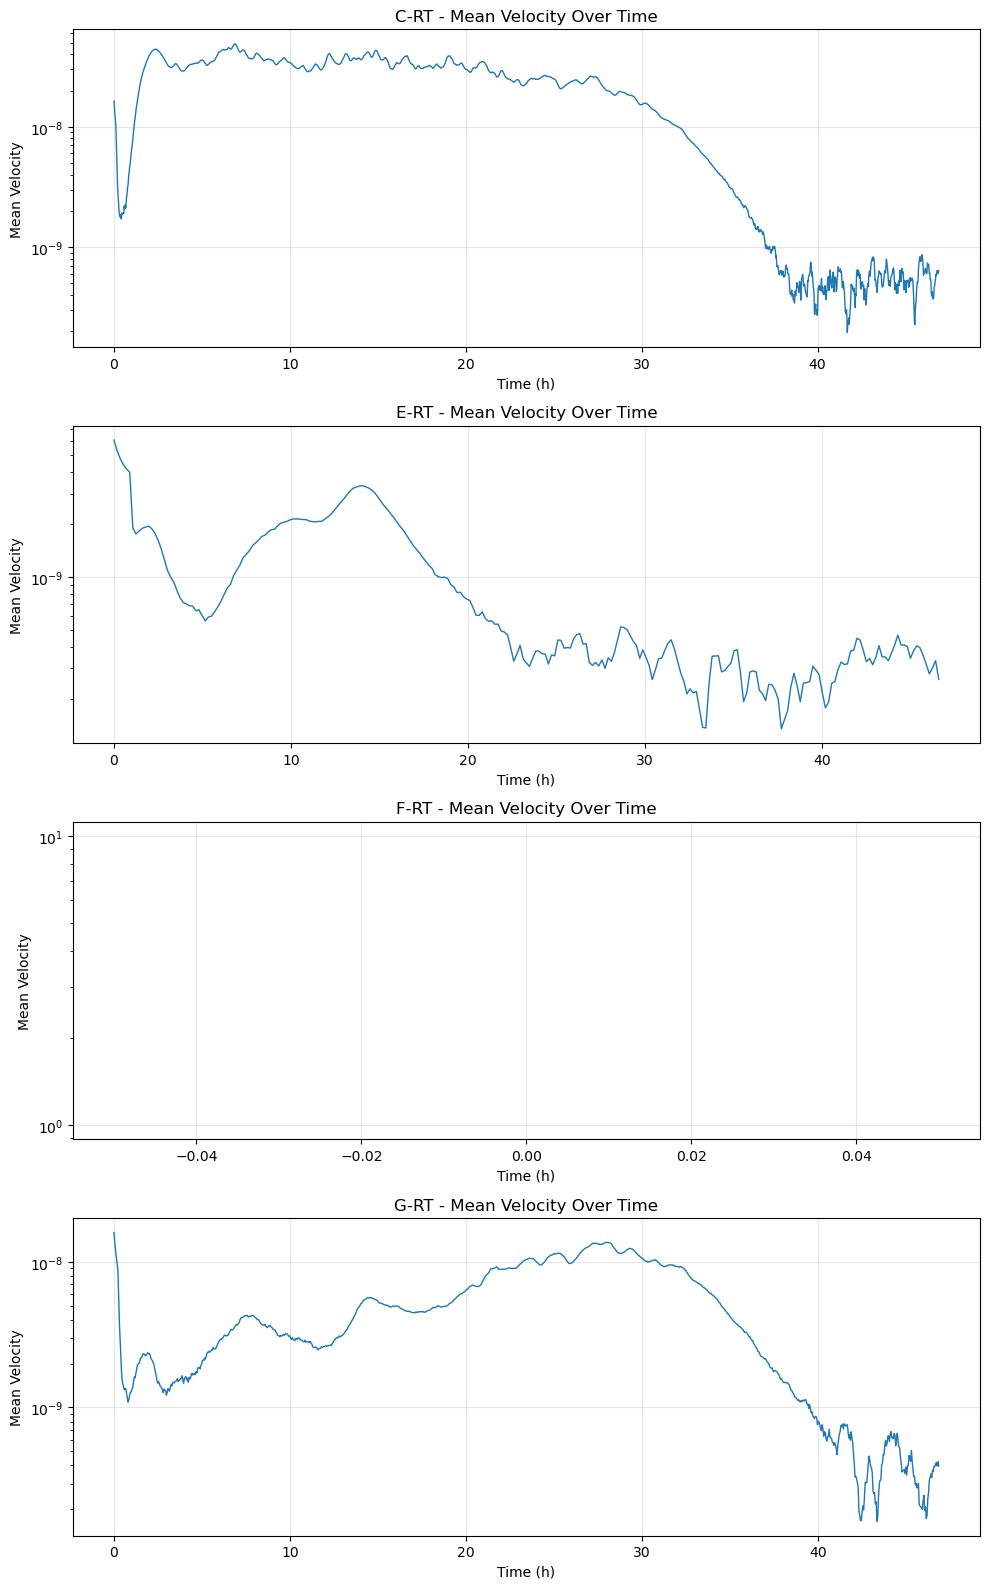

In [8]:
# Get number of conditions
conditions = df['condition'].unique()
n_conditions = len(conditions)

# Create subplots
fig, axs = plt.subplots(n_conditions, 1, figsize=(10, 4*n_conditions))

# Plot each condition in its own subplot
for i, condition in enumerate(conditions):
    subset = df[df['condition'] == condition]
    
    # For D-RT and H-RT, filter to first 4 hours
    if condition in ['D-RT', 'H-RT']:
        subset = subset[subset['time (s)'] <= 4*3600]  # 4 hours in seconds
    
    # Calculate mean across replicates for each timepoint, ignoring NaN values
    # First drop rows where velocity is NaN to avoid gaps
    subset = subset.dropna(subset=['velocity magnitude [m/s]_mean'])
    mean_data = subset.groupby('time (s)')['velocity magnitude [m/s]_mean'].mean()
    
    # Apply Gaussian filter
    smoothed_values = pd.Series(mean_data.values).rolling(window=10, center=True, min_periods=1).mean()
    
    axs[i].plot(mean_data.index/3600, smoothed_values, linewidth=1)  # Convert to hours
    axs[i].set_xlabel('Time (h)')
    axs[i].set_ylabel('Mean Velocity')
    axs[i].set_title(f'{condition} - Mean Velocity Over Time')
    axs[i].grid(True, alpha=0.3)
    axs[i].set_yscale('log')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [ ]:
# Create figure
plt.figure(figsize=(10, 6))

# Plot each condition
for condition in conditions:
    subset = df[df['condition'] == condition]
    
    # For D-RT and H-RT, filter to first 4 hours
    if condition in ['D-RT', 'H-RT']:
        subset = subset[subset['time (s)'] <= 4*3600]  # 4 hours in seconds
    
    # Calculate mean across replicates for each timepoint, ignoring NaN values
    subset = subset.dropna(subset=['velocity magnitude [m/s]_mean'])
    mean_data = subset.groupby('time (s)')['velocity magnitude [m/s]_mean'].mean()
    
    # Apply Gaussian filter
    smoothed_values = pd.Series(mean_data.values).rolling(window=10, center=True, min_periods=1).mean()
    
    plt.plot(mean_data.index/3600, smoothed_values, label=condition, linewidth=1)

plt.xlabel('Time (h)')
plt.ylabel('Mean Velocity')
plt.title('Mean Velocity Over Time - All Conditions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# Create figure
plt.figure(figsize=(10, 6))

# Plot each condition
for condition in conditions:
    subset = df[df['condition'] == condition]
    
    # For D-RT and H-RT, filter to first 4 hours
    if condition in ['D-RT', 'H-RT']:
        subset = subset[subset['time (s)'] <= 4*3600]  # 4 hours in seconds
    
    # Calculate mean across replicates for each timepoint, ignoring NaN values
    subset = subset.dropna(subset=['power [W]_mean'])
    mean_data = subset.groupby('time (s)')['power [W]_mean'].mean()
    
    # Apply Gaussian filter
    smoothed_values = pd.Series(mean_data.values).rolling(window=10, center=True, min_periods=1).mean()
    
    plt.plot(mean_data.index/3600, smoothed_values, label=condition, linewidth=1)

plt.xlabel('Time (h)')
plt.ylabel('Mean Power (W)')
plt.title('Mean Power Over Time - All Conditions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# Create figure
fig, ax = plt.subplots(figsize=(6, 8))

# Plot each condition
for condition in conditions:
    subset = df[df['condition'] == condition]
    
    # For D-RT and H-RT, filter to first 4 hours

    
    # Calculate mean across replicates for each timepoint, ignoring NaN values
    subset = subset.dropna(subset=['work [J]_mean'])
    mean_data = subset.groupby('time (s)')['work [J]_mean'].mean()
    
    # Apply Gaussian filter
    smoothed_values = pd.Series(mean_data.values).rolling(window=10, center=True, min_periods=1).mean()
    
    ax.plot(mean_data.index/3600, smoothed_values, label=condition, linewidth=1)

ax.set_xlabel('Time (h)')
ax.set_ylabel('Mean Work (J)')
ax.set_title('Mean Work Over Time - All Conditions')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Make spines thin
for spine in ax.spines.values():
    spine.set_linewidth(0.25)

# Adjust layout
plt.tight_layout()

# Save and show
plt.savefig('Fig3_.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Create figure
plt.figure(figsize=(10, 6))

# Calculate total work for each condition by summing work [J]_mean
total_work = df.groupby('condition')['work [J]_mean'].sum()

# Create bar plot
plt.bar(total_work.index, total_work.values)

plt.xlabel('Condition')
plt.ylabel('Total Work (J)')
plt.title('Total Work by Condition')
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Set y-axis to log scale

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


 1/3 portion is the first ATP binding + betaTub stabilization module. 2/3
 portion is the ATP-alphaTub-betaTub switch. 3/3 is neck linker + coiled coil

- B and F show that H1/3  with A2/3 is not functional.
- A and E show that A1/3 + A2/3 are necessary for thermal property (i.e.
  extracting work from heat!). E shows that neck linker doesn’t matter
- E and H show that A1/3 + A2/3 are necessary for the very rapid burst, but
  they do not extract work from heat
- G confirms the previous points. 1/3 K401 + 2/3 Kif3 do show motion (inverse of
  B and F). G can’t extract work from heat
- C shows that 2/3 Kif3 (switches) makes the protein significantly more capable
  of extracting motion than any other at room temperature, while 1/3 K401
  perhaps helps in stabilizing ATP or betaTub? Also 2/3H makes the protein more
  prone to act quickly? Maybe by increasing affinity for microtubules?

A and G have the same power output, but G has only A1/3 and the rest is H. That
means that single portion endows the protein with K401 force generation!

Similarly, C, D and H Have similar power outputs, although C is by far the best.
Hear me out. So D and H are basically the same, right? That means A3/3 doesn't
really matter neither for expression (well, D expresses better than H, so that
could mean that H3/3 halts expression a little bit, which makes sense because E
expresses much less than A, and also G expresses less than A, which is
compensated by H2/3!) nor for the ability to extract work or the
duration of motion. C is a super kinesin because has H2/3 which D has too, so
that makes C really active (the most, actually). 


but H2/3 has only H2/3 and the rest is A. That means that single portion endows
the protein with the ability to switch!